# 応用情報工学演習：Scikit-Learnマスターコース
## 実践編 配布用コードファイル

#### 基本ライブラリの読み込み

In [46]:
import os, sys
import glob

import warnings
warnings.simplefilter('ignore')

import numpy as np
from sklearn.metrics import accuracy_score
from PIL import Image

# 自作モジュールのインポート
from utils.train import fit, evaluate_history, generate_pseudo_labels ,torch_seed, fit_self_train
from utils.dataset import MyDataset

# 必要ライブラリのインポート
import matplotlib.pyplot as plt

# PyTorch関連ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms

# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

np.random.seed(1)

### Cudaのチェック

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### データ読み込み関数

In [48]:
#-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-#
#                               このセルは変更を禁止します                                  #
#-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-#
#-------------------------------------------------------------------------------------------#
#-                                  データ読み込み関数                                     -#
#-------------------------------------------------------------------------------------------#
def load_data_(root_dir='../data/gw_dataset'):
    """
    グループワーク用　学習用データ読み込み関数

    Args:
        * root_dir: 配布したgw_datasetへのパスを指定する (default: '../data/gw_dataset')
        
    Output:
        * X_train:  正解ラベル付き学習用画像   shape: (140x150,528)
                    1行あたり、画像1枚の画素値を格納したnp.array
                    画像140枚、各画像224x224=150,528次元のベクトル
                    
        * y_train:  X_trainの正解ラベル        shape: (140, )
                    クラス数は7　140枚分のクラスラベル（0～6）の整数が格納されている
        
        * X_trainu: 正解ラベルなし学習用画像   shape: (210x150,528)
                    形式はX_trainと同じ
                    
        * X_val:   正解ラベル付き検証用画像   shape: (70x150,528)
                    形式はX_trainと同じ
                    
        * y_val:    X_valの正解ラベル          shape: (70, )
                    形式はy_valと同じ                             
    """
    
    #----------------- 学習用データの読み込み -------------------#
    train_paths = sorted(glob.glob(os.path.join(root_dir, "train", "*.png")))
    
    X_train = np.array([np.array(Image.open(p)).astype(np.float32).ravel() for p in train_paths])
    y_train = np.load(os.path.join(root_dir, "y_train.npy"))

    #------------ ラベルなし学習用データの読み込み --------------#
    trainu_paths = sorted(glob.glob(os.path.join(root_dir, "train-u", "*.png")))
    X_trainu = np.array([np.array(Image.open(p)).astype(np.float32).ravel() for p in trainu_paths])
    
    #----------------- 検証用データの読み込み -------------------#
    val_paths = sorted(glob.glob(os.path.join(root_dir,"val", "*.png")))
    X_val = np.array([np.array(Image.open(p)).astype(np.float32).ravel() for p in val_paths])
    y_val = np.load(os.path.join(root_dir, "y_val.npy"))

    return X_train, y_train, X_trainu, X_val, y_val

In [49]:
### データ読み込み関数の実行
X_train, y_train, X_trainu, X_val, y_val = load_data_() # すべて必要な場合
print(X_train.shape, y_train.shape, X_trainu.shape, X_val.shape, y_val.shape)

# X_train, y_train, _, X_val, y_val = load_data_() # いらないデータがある場合
# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(140, 150528) (140,) (210, 150528) (70, 150528) (70,)


#### 評価関数

In [50]:
#-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-#
#                               このセルは変更を禁止します                                  #
#-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-#
#-------------------------------------------------------------------------------------------#
#-                                       評価関数                                          -#
#-------------------------------------------------------------------------------------------#

def eval_(y_pred):
    """
    グループワーク用　評価関数
    実行する前にy_valがglobalスコープに読み込まれている必要がある

    Args:
        * y_pred:   識別結果　y_valと同形式・同shapeでなければならない
    """

    try:
        y_val
    except NameError as e:
        print("y_valが読み込まれていません")
        
    assert y_pred.shape == y_val.shape, 'y_predとy_valのサイズが一致しません'
    
    print("valデータでの識別精度:{0:.3f}".format(accuracy_score(y_val, y_pred)))

### データの確認

In [51]:
# 分類先クラスのリスト作成
classes = [ '0', '1', '2', '3', '4', '5', '6']

# データを復元
X_train_reshaped = X_train.reshape(-1, 224, 224, 3)
X_val_reshaped = X_val.reshape(-1, 224, 224, 3)
X_trainu_reshaped = X_trainu.reshape(-1, 224, 224, 3)

# データセット作成
train_data = MyDataset(X_train_reshaped, y_train, type='no_trans')
val_data = MyDataset(X_val_reshaped, y_val, type='val')
trainu_data = MyDataset(X_trainu_reshaped, None, type='no_trans')

# データ件数確認
print(f'訓練データ: {len(train_data)}件')
print(f'ラベルなし訓練データ: {len(trainu_data)}件')
print(f'検証データ: {len(val_data)}件')

# データローダー作成
batch_size = 70
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
unlabeled_loader = DataLoader(trainu_data, batch_size=batch_size, shuffle=True)


訓練データ: 140件
ラベルなし訓練データ: 210件
検証データ: 70件


### モデルの定義

In [52]:
# 試行回数
num_epochs = 2000

# Consistency regularizationの重み
lambda_u = 0

# historyファイルを初期化する
history = np.zeros((0, 5), dtype=float)

# 学習モデル定義
net = models.resnet18(pretrained = True)
net.fc = nn.Linear(in_features=net.fc.in_features, out_features=7)  # 7クラスに変更

# 乱数初期化
torch_seed()

# GPUの利用
net = net.to(device)

# 学習率
lr = 1e-4

# 損失関数定義
ce = nn.CrossEntropyLoss()
mse = nn.MSELoss()

# 最適化関数定義
optimizer = optim.Adam(net.parameters(), lr=lr)

### Π-model

In [53]:
weak_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

strong_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandAugment(num_ops=2, magnitude=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
# 学習
history = np.zeros((0, 5), dtype=float)
base_epochs = len(history)
net.train()
for epoch in range(base_epochs, num_epochs + base_epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0
    for (x_l, y_l), x_u in zip(train_loader, unlabeled_loader):
        # 全てGPUへ転送
        x_l, y_l, x_u = x_l.to(device), y_l.to(device), x_u.to(device)
        
        # CPU上でPIL変換が必要なため、一旦CPUへ戻し変換後またGPUへ
        x_weak_cpu = torch.stack([weak_transform(x_u[i].cpu()) for i in range(x_u.size(0))])
        x_strong_cpu = torch.stack([strong_transform(x_u[i].cpu()) for i in range(x_u.size(0))])

        # 変換後の画像をGPUへ戻す
        x_weak = x_weak_cpu.to(device)
        x_strong = x_strong_cpu.to(device)

        # ラベルあり入力の損失計算
        z_l = net(x_l)
        loss_sup = ce(z_l, y_l)

        # ラベルなし入力の疑似ラベル生成
        with torch.no_grad():
            z_ui = net(x_weak)
            z_uj = net(x_strong)

        loss_unsup = mse(z_ui, z_uj)

        # 損失の合計
        loss = loss_sup + lambda_u * loss_unsup
        
        # 逆伝播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # ラムダの更新
    lambda_u = min(3, lambda_u + 0.001)

    # 訓練データと検証データの損失と精度を計算
    net.eval()
    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = ce(outputs, labels)
            train_loss += loss.item()
            _, preds = outputs.max(1)
            train_acc += (preds == labels).sum().item()
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = ce(outputs, labels)
            val_loss += loss.item()
            _, preds = outputs.max(1)
            val_acc += (preds == labels).sum().item()

    # 平均損失と精度の計算
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_acc = val_acc / len(val_loader.dataset)

    # エポック結果表示
    print(f"Epoch {epoch+1}/{num_epochs+base_epochs}: "
        f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")

    # 履歴更新
    history = np.vstack((history, [epoch + 1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc]))

Epoch 1/2000: Train Loss: 0.0256, Train Acc: 0.2000, Val Loss: 0.0258, Val Acc: 0.2143
Epoch 2/2000: Train Loss: 0.0157, Train Acc: 0.8357, Val Loss: 0.0221, Val Acc: 0.3714
Epoch 3/2000: Train Loss: 0.0064, Train Acc: 0.9571, Val Loss: 0.0178, Val Acc: 0.5857
Epoch 4/2000: Train Loss: 0.0021, Train Acc: 0.9786, Val Loss: 0.0141, Val Acc: 0.6143
Epoch 5/2000: Train Loss: 0.0005, Train Acc: 1.0000, Val Loss: 0.0169, Val Acc: 0.5857
Epoch 6/2000: Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0111, Val Acc: 0.7000
Epoch 7/2000: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0130, Val Acc: 0.7429
Epoch 8/2000: Train Loss: 0.0036, Train Acc: 0.8857, Val Loss: 0.0325, Val Acc: 0.5000
Epoch 9/2000: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0140, Val Acc: 0.6571
Epoch 10/2000: Train Loss: 0.0007, Train Acc: 0.9786, Val Loss: 0.0157, Val Acc: 0.6571
Epoch 11/2000: Train Loss: 0.0005, Train Acc: 1.0000, Val Loss: 0.0169, Val Acc: 0.5857
Epoch 12/2000: Train Loss: 0.0001, Train 

[初期状態] loss: 0.02576, accuracy: 0.21429
[最終状態] loss: 0.01457, accuracy: 0.77143


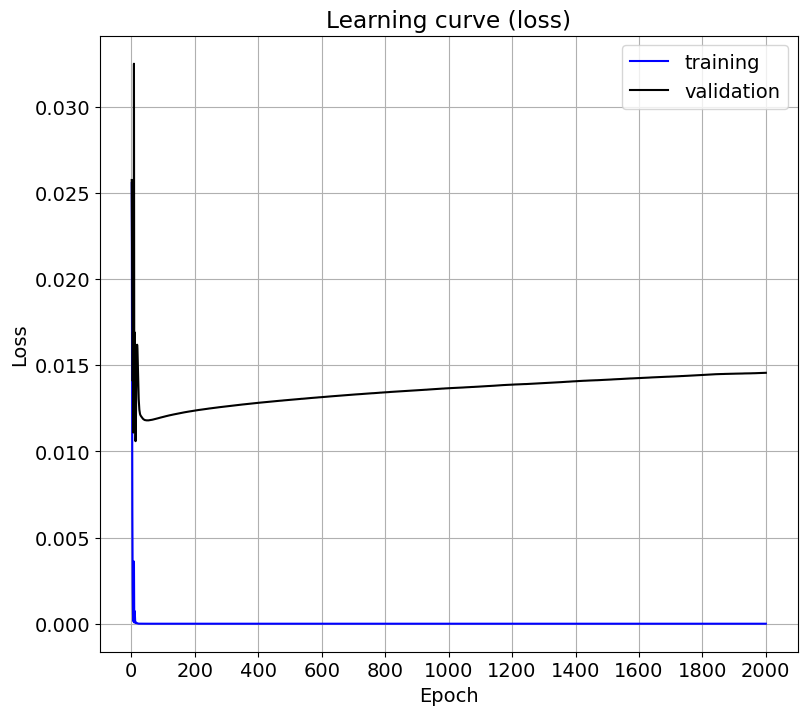

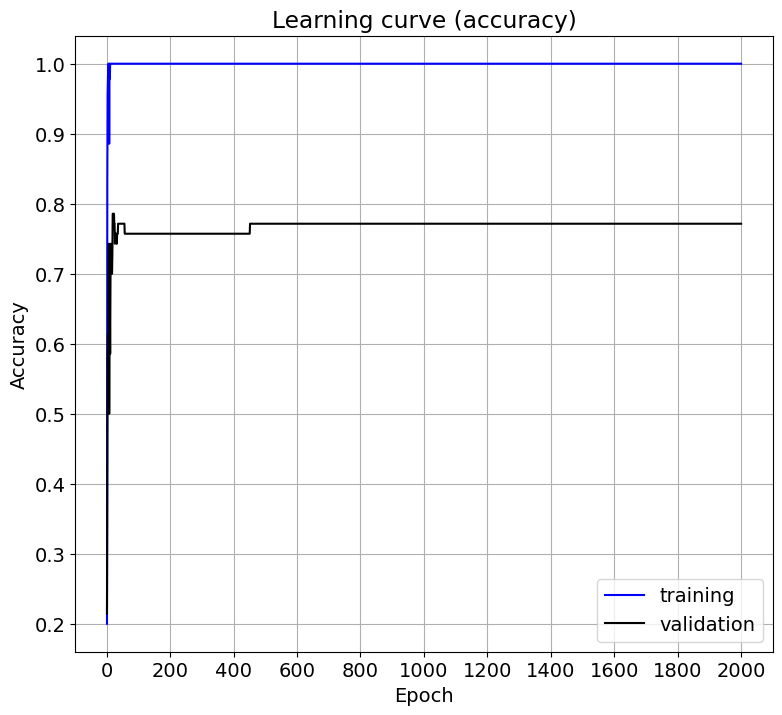

In [55]:
# 結果確認
evaluate_history(history)

### モデルの保存

In [56]:
path = 'model.pth'
torch.save(net.state_dict(), path)